In [1]:
import src.test_functions as test_functions

In [2]:
import scipy
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1'

In [5]:
def sample(function, bounds, n, local_minima=False):
    assert isinstance(bounds, np.ndarray)
    assert bounds.shape[1] == 2
    xs = np.random.rand(n, bounds.shape[0]) * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
    ys = np.array([function(x).item() for x in xs])
    
    if local_minima:
        xs_local_opt = []
        ys_local_opt = []
        for x0 in xs:
            opt_res = scipy.optimize.minimize(func, x0, method='Nelder-Mead')
            if opt_res.success:
                xs_local_opt.append(opt_res.x)
                ys_local_opt.append(opt_res.fun)
        xs_local_opt, ys_local_opt = np.array(xs_local_opt), np.array(ys_local_opt)
        return xs, ys, xs_local_opt, ys_local_opt
    
    return xs, ys

In [6]:
dimension = 1

func = test_functions.Ackley(dims=dimension)
# variables, expression = func.expression()

bounds = func.get_default_domain()
lb = bounds.T[0]
ub = bounds.T[1]

In [7]:
xs = np.arange(lb[0], ub[0], 0.01)
ys = np.array([func(np.array([x])).item() for x in xs])

# sampled_xs, sampled_ys = sample(func, bounds, 100)
sampled_xs, sampled_ys, sampled_xs_local_min, sampled_ys_local_min = sample(func, bounds, 100, local_minima=True)

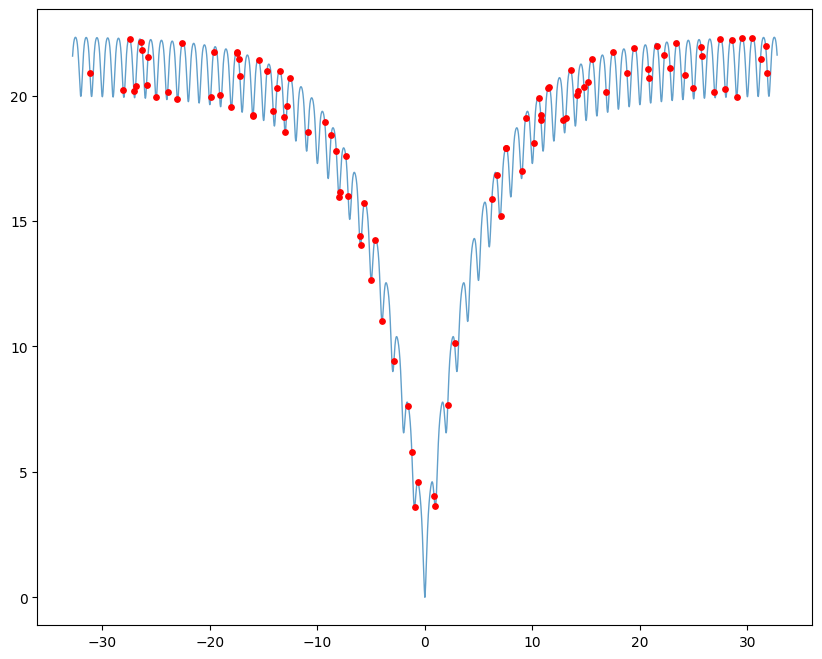

In [8]:
fig = plt.figure(figsize=(10,8))
plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


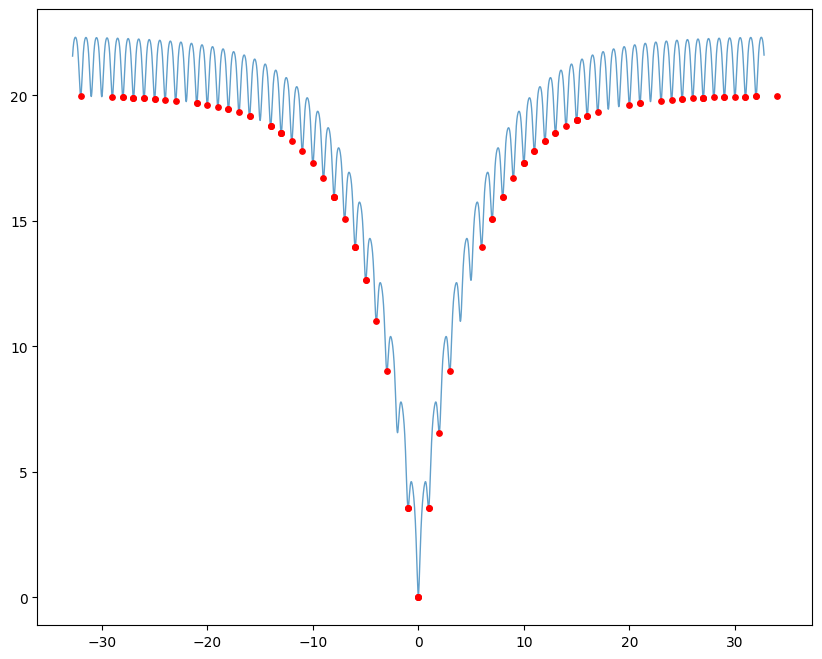

In [9]:
fig = plt.figure(figsize=(10,8))
# plt.scatter(sampled_xs[:, 0], sampled_ys, s=15, c='red', zorder=10)
plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)


## Fit a neural network

In [10]:
import torch.nn as nn
import torch

from tqdm import tqdm

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
xs_train = sampled_xs
ys_train = np.expand_dims(sampled_ys, axis=1)

In [13]:
hidden_dim = 16

model = nn.Sequential(
    nn.Linear(dimension, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1)
)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 10000

model.to(device)

loss_record = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    x_train_tensor = torch.FloatTensor(xs_train).to(device)
    y_train_tensor = torch.FloatTensor(ys_train).to(device)
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    loss_record.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1593.12it/s]


In [16]:
with torch.no_grad():
    fitted_ys = model(torch.FloatTensor(np.expand_dims(xs, axis=1)).to(device)).detach().cpu().squeeze().numpy()

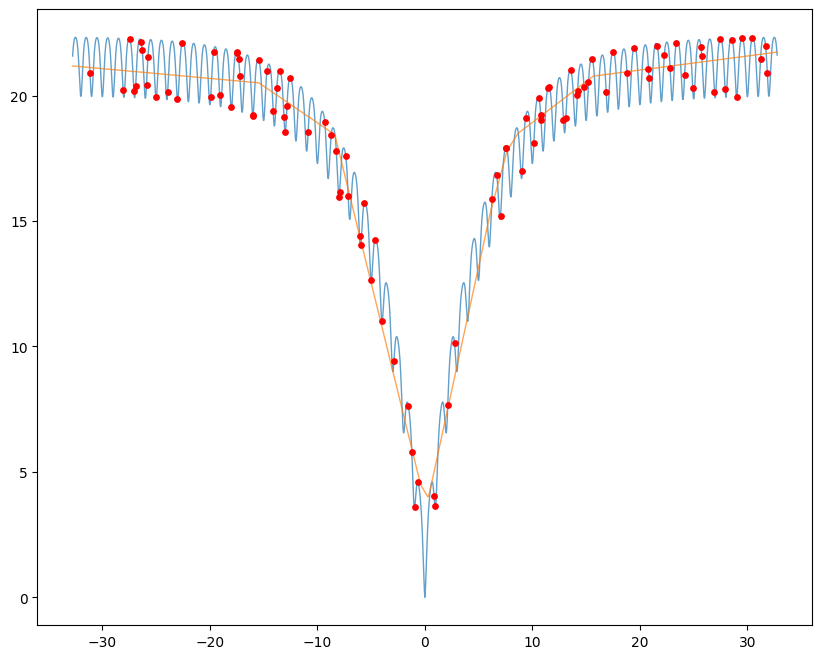

In [17]:
fig = plt.figure(figsize=(10,8))

plt.scatter(xs_train[:, 0], ys_train[:, 0], s=15, c='red', zorder=10)
# plt.scatter(sampled_xs_local_min[:, 0], sampled_ys_local_min, s=15, c='red', zorder=10)

plt.plot(xs, ys, zorder=1, linewidth=1, alpha=0.7)
plt.plot(xs, fitted_ys, linewidth=1, alpha=0.7)

In [174]:
from sympy import symbols, Max
import sympy

In [175]:
layer_idx = 2
layer = model[layer_idx]

In [176]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [177]:
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [178]:
inter_vars

(x[2][0],
 x[2][1],
 x[2][2],
 x[2][3],
 x[2][4],
 x[2][5],
 x[2][6],
 x[2][7],
 x[2][8],
 x[2][9],
 x[2][10],
 x[2][11],
 x[2][12],
 x[2][13],
 x[2][14],
 x[2][15])

In [179]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [180]:
W = weight.detach().cpu().numpy()

In [181]:
b = bias.detach().cpu().numpy()
b

array([1.066176], dtype=float32)

In [182]:
expression = (W @ X).squeeze(axis=1) + b
expression = expression.item()

In [183]:
layer_idx = 1
layer = model[layer_idx]
layer

ReLU()

In [184]:
prev_inter_vars = inter_vars
width = len(inter_vars)
inter_vars = symbols(', '.join(['x[{}][{}]'.format(layer_idx, i) for i in range(width)]))

In [185]:
inter_vars[0]

x[1][0]

In [186]:
replace_dict = {}
for curr_var, prev_var in zip(inter_vars, prev_inter_vars):
    replace_dict[prev_var] = Max(curr_var, 0)

In [187]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [188]:
expression

0.706566333770752*Max(0, x[1][0]) + 0.557638645172119*Max(0, x[1][10]) + 0.560592532157898*Max(0, x[1][11]) - 0.0326119475066662*Max(0, x[1][12]) + 0.452382296323776*Max(0, x[1][13]) - 2.18451547622681*Max(0, x[1][14]) - 0.0916549265384674*Max(0, x[1][15]) + 0.0922621637582779*Max(0, x[1][1]) + 2.62155294418335*Max(0, x[1][2]) - 1.47286367416382*Max(0, x[1][3]) - 0.578965902328491*Max(0, x[1][4]) + 0.412133783102036*Max(0, x[1][5]) - 1.24104559421539*Max(0, x[1][6]) - 0.204787731170654*Max(0, x[1][7]) - 1.36862349510193*Max(0, x[1][8]) - 0.728818476200104*Max(0, x[1][9]) + 1.06617605686188

In [189]:
layer_idx = 0
layer = model[layer_idx]
layer

Linear(in_features=1, out_features=16, bias=True)

In [190]:
weight = layer.weight
bias = layer.bias
width = weight.shape[1]

In [191]:
prev_inter_vars = inter_vars
inter_vars = symbols(', '.join(['x[{}]'.format(i) for i in range(width)]))
if isinstance(inter_vars, sympy.Symbol):
    inter_vars = [inter_vars]

In [192]:
X = np.expand_dims(np.array(inter_vars), axis=1)

In [193]:
W = weight.detach().cpu().numpy()

In [194]:
b = bias.detach().cpu().numpy()
b

array([ 0.42103446, -0.18516287,  4.4840117 ,  4.6566978 , -4.2021704 ,
        0.6010146 , -3.4082015 , -0.5494977 , -2.858165  ,  4.188088  ,
        0.5564801 ,  0.48046622, -0.35487747,  0.3730188 , -5.587867  ,
       -0.35892335], dtype=float32)

In [195]:
mat_res = (W @ X).squeeze(axis=1) + b

In [196]:
replace_dict = {}
for curr_expr, prev_var in zip(mat_res, prev_inter_vars):
    replace_dict[prev_var] = curr_expr
replace_dict

{x[1][0]: 0.421034455299377 - 1.27895355224609*x[0],
 x[1][1]: 0.251966446638107*x[0] - 0.185162872076035,
 x[1][2]: 4.48401165008545 - 0.114487566053867*x[0],
 x[1][3]: 4.65669775009155 - 0.609095692634583*x[0],
 x[1][4]: 0.690118730068207*x[0] - 4.20217037200928,
 x[1][5]: 1.24792158603668*x[0] + 0.601014614105225,
 x[1][6]: 0.217817232012749*x[0] - 3.40820145606995,
 x[1][7]: -0.0128339529037476*x[0] - 0.549497723579407,
 x[1][8]: -0.185042083263397*x[0] - 2.85816502571106,
 x[1][9]: 4.18808794021606 - 0.484238147735596*x[0],
 x[1][10]: 0.55648010969162 - 2.06908750534058*x[0],
 x[1][11]: 0.480466216802597 - 1.14518690109253*x[0],
 x[1][12]: 0.798190832138062*x[0] - 0.354877471923828,
 x[1][13]: 1.13726687431335*x[0] + 0.373018801212311,
 x[1][14]: -0.667178332805634*x[0] - 5.58786678314209,
 x[1][15]: 0.0112305758520961*x[0] - 0.358923345804214}

In [197]:
prev_expression = expression
for key in replace_dict:
    expression = expression.subs(key, replace_dict[key])

In [198]:
str(expression)

'0.706566333770752*Max(0, 0.421034455299377 - 1.27895355224609*x[0]) + 0.560592532157898*Max(0, 0.480466216802597 - 1.14518690109253*x[0]) + 0.557638645172119*Max(0, 0.55648010969162 - 2.06908750534058*x[0]) - 0.728818476200104*Max(0, 4.18808794021606 - 0.484238147735596*x[0]) + 2.62155294418335*Max(0, 4.48401165008545 - 0.114487566053867*x[0]) - 1.47286367416382*Max(0, 4.65669775009155 - 0.609095692634583*x[0]) - 2.18451547622681*Max(0, -0.667178332805634*x[0] - 5.58786678314209) - 1.36862349510193*Max(0, -0.185042083263397*x[0] - 2.85816502571106) - 0.204787731170654*Max(0, -0.0128339529037476*x[0] - 0.549497723579407) - 0.0916549265384674*Max(0, 0.0112305758520961*x[0] - 0.358923345804214) - 1.24104559421539*Max(0, 0.217817232012749*x[0] - 3.40820145606995) + 0.0922621637582779*Max(0, 0.251966446638107*x[0] - 0.185162872076035) - 0.578965902328491*Max(0, 0.690118730068207*x[0] - 4.20217037200928) - 0.0326119475066662*Max(0, 0.798190832138062*x[0] - 0.354877471923828) + 0.45238229632

In [23]:
for layer in model[::-1]:
    if isinstance(layer, nn.Linear):
        print(True)
    print(layer)

True
Linear(in_features=16, out_features=1, bias=True)
ReLU()
True
Linear(in_features=1, out_features=16, bias=True)


In [18]:
model

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=1, bias=True)
)

In [19]:
model[0].weight

Parameter containing:
tensor([[-1.2790],
        [ 0.2520],
        [-0.1145],
        [-0.6091],
        [ 0.6901],
        [ 1.2479],
        [ 0.2178],
        [-0.0128],
        [-0.1850],
        [-0.4842],
        [-2.0691],
        [-1.1452],
        [ 0.7982],
        [ 1.1373],
        [-0.6672],
        [ 0.0112]], device='cuda:0', requires_grad=True)

In [20]:
model[0].bias

Parameter containing:
tensor([ 0.4210, -0.1852,  4.4840,  4.6567, -4.2022,  0.6010, -3.4082, -0.5495,
        -2.8582,  4.1881,  0.5565,  0.4805, -0.3549,  0.3730, -5.5879, -0.3589],
       device='cuda:0', requires_grad=True)